## **Laboratorio 5 - Data Science**
### *Autocodificadores*
Stefano Aragoni, Carol Arévalo

----------

#### **Parte 1**: Preparación de Datos

Como primer paso, se importan las librerías necesarias para el desarrollo del laboratorio.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler

Posteriormente, se <font color=orange>cargaron los datos a un DataFrame de Pandas </font>.

En este caso se tienen 5 columnas;

1. La primera columna corresponde al nombre del producto.
2. Las siguientes 4 columnas corresponden al consumo, en gramos por persona por semana de diferentes comidas en cuatro países del Reino Unido

In [51]:
# Cargue los datos en un DataFrame de Pandas
data = pd.read_csv('UK_foods.csv')

print(data.shape)

data.head(10)

(17, 5)


,Unnamed: 0,England,Wales,Scotland,N.Ireland
0,Cheese,105,103,103,66
1,Carcass_meat,245,227,242,267
2,Other_meat,685,803,750,586
3,Fish,147,160,122,93
4,Fats_and_oils,193,235,184,209
5,Sugars,156,175,147,139
6,Fresh_potatoes,720,874,566,1033
7,Fresh_Veg,253,265,171,143
8,Other_Veg,488,570,418,355
9,Processed_potatoes,198,203,220,187


Sin embargo, se realiza la transpuesta de los datos para que las columnas correspondan a los productos y las filas a los países. Esto para poder posteriormente reducir de 17 dimensiones a 2 dimensiones.

Con eso listo, se realizó una <font color=orange>exploración básica de los datos (estadísticas descriptivas)</font>.

Como primer paso, se observó si existían valores nulos o faltantes en el DataFrame, lo cual no fue el caso.

In [45]:
# Verificar si hay valores faltantes o nulos
missing_values = data.isnull().sum()
print("Valores faltantes o nulos por columna:")
print(missing_values)


Valores faltantes o nulos por columna:
Unnamed: 0    0
England       0
Wales         0
Scotland      0
N.Ireland     0
dtype: int64


Posteriormente, se analizó la distribución de los datos. En este caso se puede observar como Scotland y N. Ireland son los únicos países con valores atípicos. Posiblemente, en estos países se consumen menos gramos de comida por persona por semana.

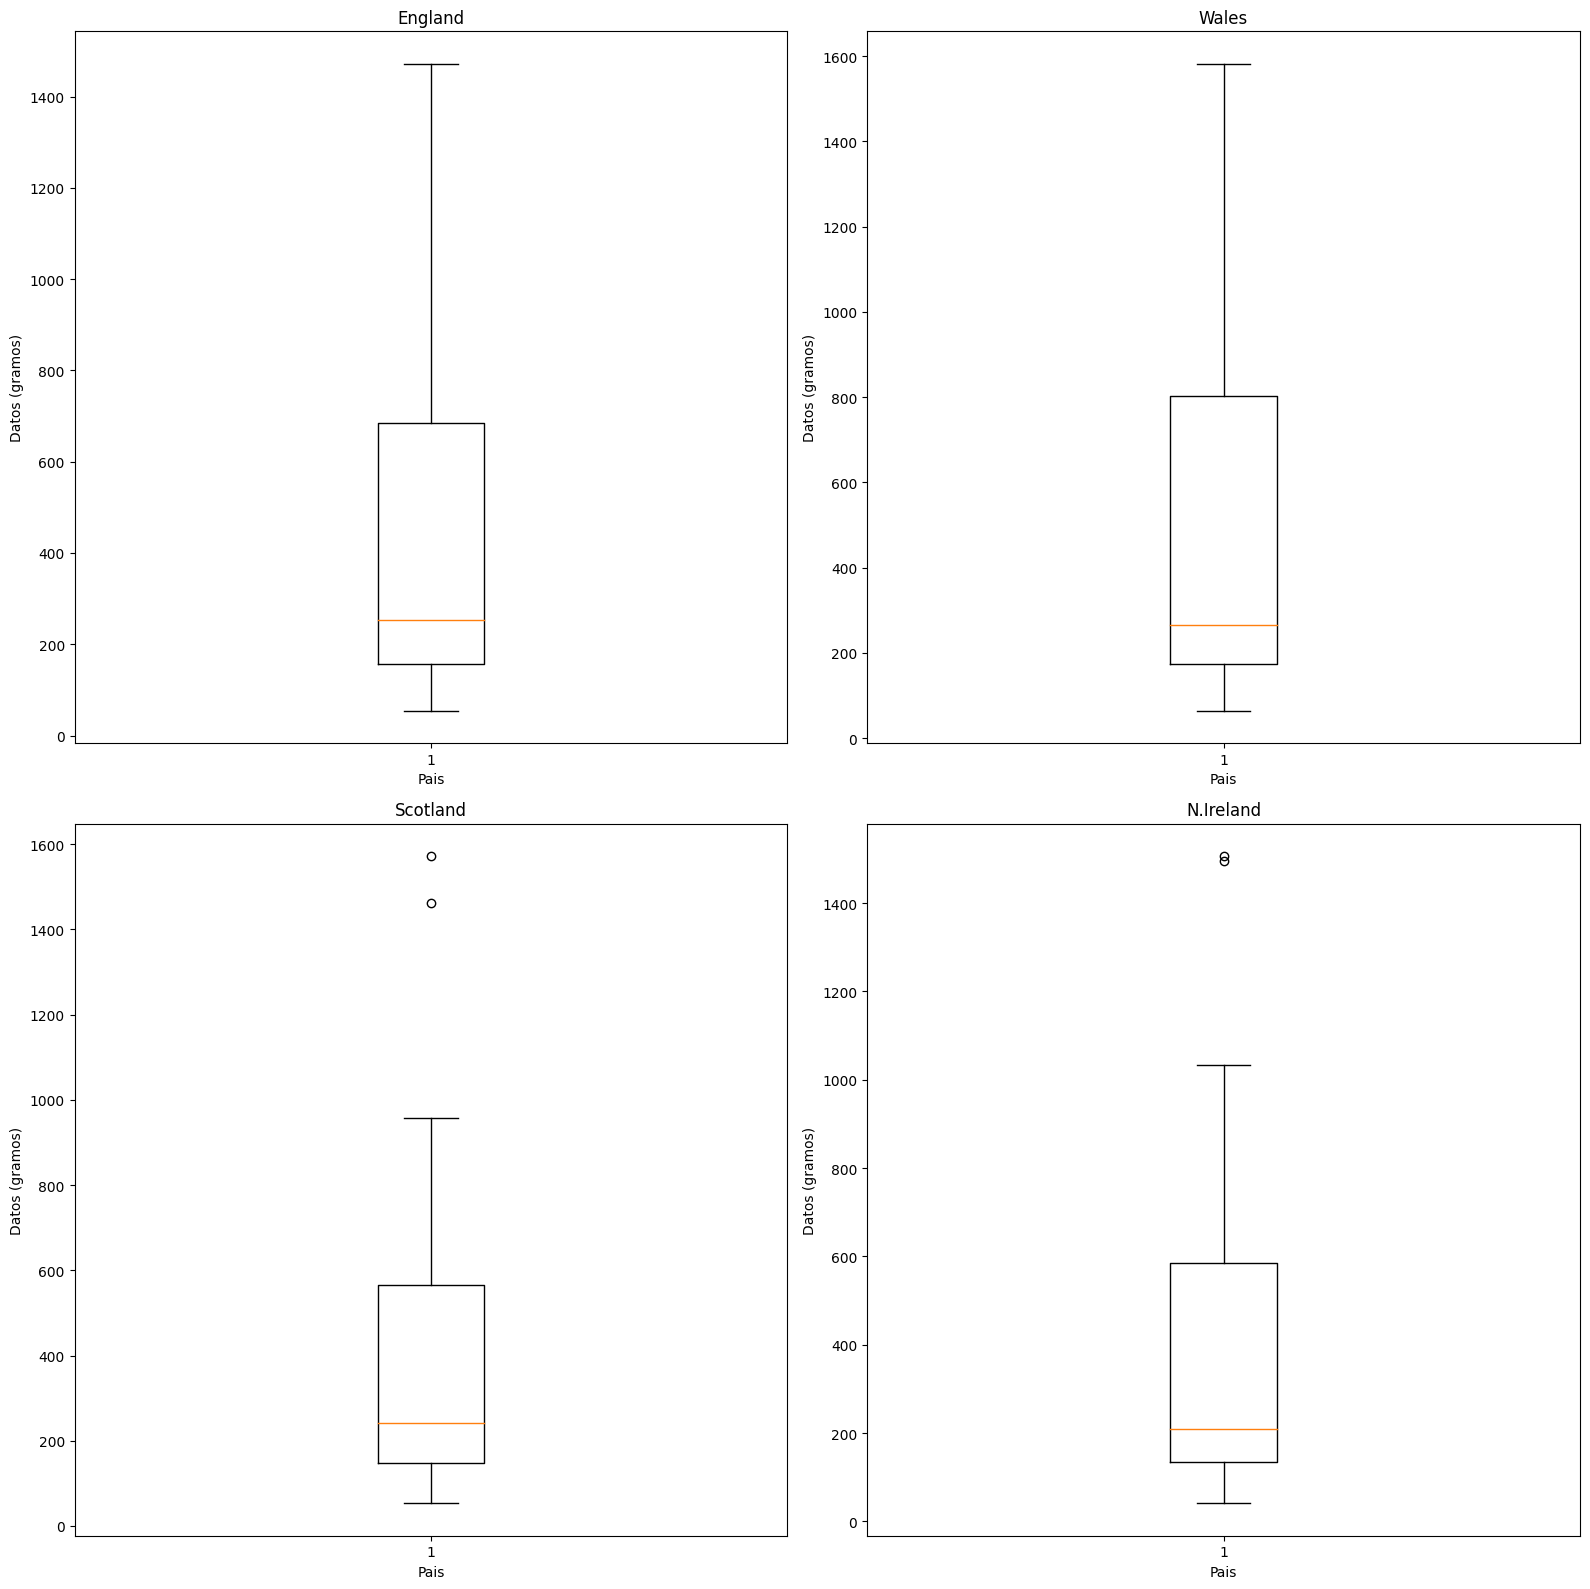

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

numeric_data = data.select_dtypes(include=[np.number])
for i, column in enumerate(numeric_data.columns):
    ax = axes[i]
    ax.set_title(column)
    ax.set_xlabel('Pais')
    ax.set_ylabel('Datos (gramos)')
    ax.boxplot(numeric_data[column])


plt.tight_layout()
plt.show()

Asimismo, se realizó un análisis de *estadísticas descriptivas*. Como se puede observar, la media de consumo de comida por persona por semana es de 400 a 500 gramos. Asimismo, se puede observar que la desviación estándar es de ronda alrededor de los 450 gramos. 

Esto indica que es necesario realizar una **normalización de los datos**, para que los valores de las columnas estén en un rango similar.

In [47]:
# Estadísticas descriptivas detalladas
detailed_stats = numeric_data.describe(percentiles=[0.25, 0.5, 0.75])
print("Estadísticas descriptivas detalladas:")
print(detailed_stats)

Estadísticas descriptivas detalladas:
           England        Wales     Scotland    N.Ireland
count    17.000000    17.000000    17.000000    17.000000
mean    469.647059   503.941176   460.235294   429.941176
std     452.701466   463.859282   469.595907   479.896014
min      54.000000    64.000000    53.000000    41.000000
25%     156.000000   175.000000   147.000000   135.000000
50%     253.000000   265.000000   242.000000   209.000000
75%     685.000000   803.000000   566.000000   586.000000
max    1472.000000  1582.000000  1572.000000  1506.000000


Finalmente, se realizó una <font color=orange>normalización de los datos</font>. En este caso se utilizó la función StandardScaler de la librería sklearn.

In [48]:
# Normalizar los datos
scaler = StandardScaler()
numeric_cols = ['England', 'Wales', 'Scotland', 'N.Ireland']
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

normalized_data = data[numeric_cols]

#### **Parte 2**: Construcción del Autocodificador

Debido a que solo hay 17 datos, se utilizó todos los datos para el entrenamiento del autocodificador.

In [52]:
X_train = normalized_data

ValueError: test_size=0 should be either positive and smaller than the number of samples 17 or a float in the (0, 1) range

In [50]:
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping


# Definir la arquitectura del autocodificador
input_layer = Input(shape=(len(4),))
encoded = Dense(400, activation='relu')(input_layer)
encoded = Dense(200, activation='relu')(encoded)
encoded = Dense(100, activation='relu')(encoded)
encoded = Dense(50, activation='relu')(encoded)
encoded = Dense(25, activation='relu')(encoded)

decoded = Dense(50, activation='relu')(encoded)
decoded = Dense(100, activation='relu')(decoded)
decoded = Dense(200, activation='relu')(decoded)
decoded = Dense(400, activation='relu')(decoded)
decoded = Dense(len(4), activation='linear')(decoded)

# Compilar el modelo
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Configurar EarlyStopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo y evaluar en el conjunto de prueba en cada época
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping]
)


# Visualizar la pérdida en entrenamiento y prueba
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


2023-09-25 16:09:15.357439: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Utilizar el autocodificador para reconstruir los datos del conjunto de prueba
reconstructed_data = autoencoder.predict(X_test)

# Calcular el error de reconstrucción (puedes usar la media del error cuadrado)

reconstruction_error = mean_squared_error(X_test, reconstructed_data)
print("Error de reconstrucción en el conjunto de prueba:", reconstruction_error)


# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(X_test, reconstructed_data)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(X_test, reconstructed_data)

# Calcular el coeficiente de determinación (R2)
r2 = r2_score(X_test, reconstructed_data)

# Imprimir las métricas
print("Error cuadrático medio (MSE):", mse)
print("Error absoluto medio (MAE):", mae)
print("Coeficiente de determinación (R2):", r2)



1/1 [==============================] - 0s 44ms/step
Error de reconstrucción en el conjunto de prueba: 0.02447955790276618
Error cuadrático medio (MSE): 0.02447955790276618
Error absoluto medio (MAE): 0.11182775394222226
Coeficiente de determinación (R2): 0.3275429003652793


Un error de reconstrucción de aproximadamente 0.0244 indica que el autoencoder está haciendo un buen trabajo al comprimir y luego descomprimir los datos, y la reconstrucción es bastante precisa en comparación con los datos originales. Asimismo el valor del MSE sugiere que la calidad de la reconstrucción es relativamente buena, pero aún hay margen de mejora.. Un MAE de 0 indicaría una reconstrucción perfecta. En este caso, el MAE es de aproximadamente 0.1118. El MAE es un poco más alto que el MSE, lo que sugiere que algunos errores individuales pueden ser mayores, pero en promedio, los errores son relativamente bajos.

Parte 3: Reducción de Dimensionalidad y Visualización 


In [ ]:
# Utilizar el autocodificador para reducir las dimensiones del conjunto de datos a 2
encoder = Model(input_layer, encoded)
encoded_data = encoder.predict(normalized_data)

1/1 [==============================] - 0s 107ms/step


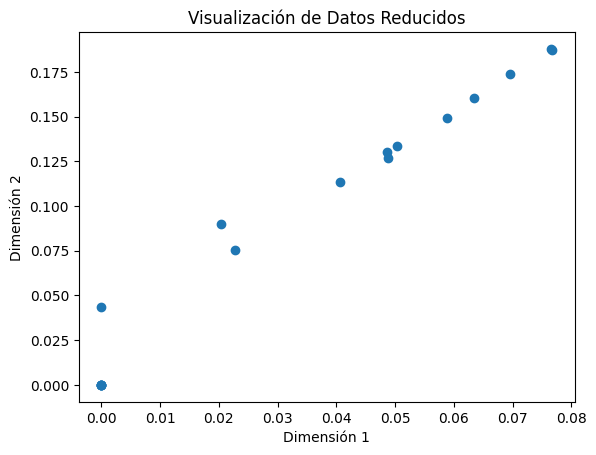

In [ ]:
# Visualizar las dos dimensiones en un gráfico de dispersión
import matplotlib.pyplot as plt
plt.scatter(encoded_data[:, 0], encoded_data[:, 1])
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.title('Visualización de Datos Reducidos')
plt.show()

Parte 4: Discusión y percepciones nuevas "Insights" 

